In [ ]:
csv_path = "./Traffic_Crashes_-_Crashes.csv"

In [ ]:
# !pip install -- geopandas
# !pip install -- geoplot
# !pip install factor_analyzer

In [ ]:
import os
import pandas as pd
import numpy as np
from collections import Counter
import shapely
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geoplot
import geoplot.crs as gcrs
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, PredefinedSplit, RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer, accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
import seaborn as sns
from sklearn.metrics import roc_curve, confusion_matrix
import matplotlib.pyplot as plt

# Data Cleaning

#### Count number of missing values in each row, then drop variables with more than 100,000 NAs

In [ ]:
# read data
df = pd.read_csv(csv_path)
# number of NA in each row
print(df.isna().sum())
# drop variables with more than 100,000 NAs
perserve_column = list() # columns to perserve
for i in df.columns:
    if df[i].isna().sum() < 100000:
        perserve_column.append(i)
df = df[perserve_column]
print(df.isna().sum())

CRASH_RECORD_ID                       0
RD_NO                              4128
CRASH_DATE_EST_I                 553066
CRASH_DATE                            0
POSTED_SPEED_LIMIT                    0
TRAFFIC_CONTROL_DEVICE                0
DEVICE_CONDITION                      0
WEATHER_CONDITION                     0
LIGHTING_CONDITION                    0
FIRST_CRASH_TYPE                      0
TRAFFICWAY_TYPE                       0
LANE_CNT                         399303
ALIGNMENT                             0
ROADWAY_SURFACE_COND                  0
ROAD_DEFECT                           0
REPORT_TYPE                       15356
CRASH_TYPE                            0
INTERSECTION_RELATED_I           461624
NOT_RIGHT_OF_WAY_I               570115
HIT_AND_RUN_I                    415656
DAMAGE                                0
DATE_POLICE_NOTIFIED                  0
PRIM_CONTRIBUTORY_CAUSE               0
SEC_CONTRIBUTORY_CAUSE                0
STREET_NO                             0


In [ ]:
#drop row with NA
df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)

In [ ]:
df

,CRASH_RECORD_ID,RD_NO,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,000cd9ff5c7aa5448f9ed6058c7b3f6b8504d234fa5cb7...,JF153597,02/23/2022 12:15:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,NOT REPORTED,...,0.0,0.0,2.0,0.0,12,4,2,41.876038,-87.701103,POINT (-87.701103023191 41.876038171488)
1,0052353fae536fede6e12ddeb02d595269b9710f0cb99d...,JF160439,03/02/2022 12:01:00 AM,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,ONE-WAY,...,0.0,0.0,1.0,0.0,0,4,3,41.754258,-87.653105,POINT (-87.653104943768 41.754258080908)
2,0056da66abbbe3801471a3b091e81b7a7a647d8b5370ca...,JF146223,02/16/2022 11:30:00 AM,15,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,REAR TO REAR,PARKING LOT,...,0.0,0.0,2.0,0.0,11,4,2,41.909765,-87.743376,POINT (-87.743376295706 41.909764527033)
3,00bf17f37976df288c78c8f3ccc6029818354482437c57...,JF153612,02/23/2022 12:30:00 PM,20,NO CONTROLS,NO CONTROLS,CLEAR,DAWN,SIDESWIPE SAME DIRECTION,PARKING LOT,...,0.0,0.0,2.0,0.0,12,4,2,41.783922,-87.607323,POINT (-87.607322913783 41.78392235273)
4,00a06d9bf293ef87873d9ce07631fbf247263cbb747869...,JF160510,03/02/2022 04:15:00 AM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,FOUR WAY,...,0.0,0.0,3.0,0.0,4,4,3,41.778538,-87.742356,POINT (-87.74235587842 41.778538071066)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574191,d8884f2febe11f475595442df095dc52ccf35b3ca0cde4...,JF161018,03/02/2022 02:30:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,NOT DIVIDED,...,0.0,0.0,2.0,0.0,14,4,3,41.867340,-87.641502,POINT (-87.641502099152 41.867340031065)
574192,e732abec9e82d5b35314d4dff9a00e22b03ea3b73ef45f...,JF161081,03/02/2022 01:45:00 PM,30,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,ANGLE,DIVIDED - W/MEDIAN (NOT RAISED),...,0.0,0.0,2.0,0.0,13,4,3,41.869311,-87.670599,POINT (-87.670598682097 41.869310907082)
574193,8ec92809e8ce5a174dd081f7ee9f8ff34786d0af53ae2a...,JF161410,02/19/2022 09:40:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,...,1.0,0.0,1.0,0.0,21,7,2,41.852445,-87.642294,POINT (-87.642294286837 41.852445144074)
574194,c79ab9d471c3942db14ef3ad16497e2ffb28e24ad44b67...,JF160931,03/01/2022 08:00:00 PM,15,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,PARKING LOT,...,0.0,0.0,1.0,0.0,20,3,3,41.691679,-87.679779,POINT (-87.679779172526 41.691679204031)


# Remove Corrupted Data

#### Generate descriptive statistics of perserved numeric variables

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
POSTED_SPEED_LIMIT,574196.0,28.338916,6.331716,0.000000,30.000000,30.000000,30.000000,99.00000
STREET_NO,574196.0,3678.545479,2841.536995,1.000000,1234.000000,3200.000000,5600.000000,13799.00000
BEAT_OF_OCCURRENCE,574196.0,1238.439564,706.225488,111.000000,712.000000,1135.000000,1822.000000,2535.00000
NUM_UNITS,574196.0,2.031197,0.439770,1.000000,2.000000,2.000000,2.000000,18.00000
INJURIES_TOTAL,574196.0,0.176954,0.543201,0.000000,0.000000,0.000000,0.000000,21.00000
INJURIES_FATAL,574196.0,0.000932,0.033084,0.000000,0.000000,0.000000,0.000000,3.00000
INJURIES_INCAPACITATING,574196.0,0.018934,0.160048,0.000000,0.000000,0.000000,0.000000,6.00000
INJURIES_NON_INCAPACITATING,574196.0,0.099250,0.404919,0.000000,0.000000,0.000000,0.000000,21.00000
INJURIES_REPORTED_NOT_EVIDENT,574196.0,0.057837,0.307159,0.000000,0.000000,0.000000,0.000000,15.00000
INJURIES_NO_INDICATION,574196.0,2.011810,1.159167,0.000000,1.000000,2.000000,2.000000,61.00000


#### By observing the above table, we can see that the variable 'INJURIES_UNKNOWN' is 0 for all data. Therefore, we will remove it. Also, we will remove the data that has 0 in 'LATITUDE' or 0 in 'LONGITUDE'


In [ ]:
df.drop(['INJURIES_UNKNOWN'], axis = 1, inplace = True)
df = df.loc[(df['LATITUDE'] != 0) & df['LONGITUDE']!=0]
df.reset_index(drop = True, inplace = True)

In [ ]:
df = df.loc[df['TRAFFIC_CONTROL_DEVICE']!='UNKNOWN']
df = df.loc[df['DEVICE_CONDITION']!='UNKNOWN']
df = df.loc[df['WEATHER_CONDITION']!='UNKNOWN']
df = df.loc[df['LIGHTING_CONDITION']!='UNKNOWN']
df = df.loc[df['TRAFFICWAY_TYPE']!='UNKNOWN']
df = df.loc[df['ROADWAY_SURFACE_COND']!='UNKNOWN']
df = df.loc[df['ROAD_DEFECT']!='UNKNOWN']

In [ ]:
df.drop(['CRASH_RECORD_ID', 'RD_NO', 'CRASH_DATE', 'STREET_NAME', 'DATE_POLICE_NOTIFIED', 'LOCATION', 'MOST_SEVERE_INJURY'], axis=1, inplace=True)
df.reset_index(drop = True, inplace = True)

In [ ]:
print(df.shape)

(459855, 30)


#### Create the dependent variable 'DAMAGE_over_1500'

In [ ]:
damage_over_1500 = list()
for i in range(len(df)):
  if (df.loc[i, 'DAMAGE'] == 'OVER $1,500') == True:
    damage_over_1500.append(1)
  else:
    damage_over_1500.append(0)
df['DAMAGE_OVER_1500'] = damage_over_1500
df['DAMAGE_OVER_1500'] = df['DAMAGE_OVER_1500'].astype('category')

In [ ]:
df

,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,...,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,DAMAGE_OVER_1500
0,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,ONE-WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,0.0,1.0,0,4,3,41.754258,-87.653105,0
1,15,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,REAR TO REAR,PARKING LOT,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,0.0,2.0,11,4,2,41.909765,-87.743376,1
2,20,NO CONTROLS,NO CONTROLS,CLEAR,DAWN,SIDESWIPE SAME DIRECTION,PARKING LOT,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,0.0,2.0,12,4,2,41.783922,-87.607323,0
3,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,0.0,3.0,4,4,3,41.778538,-87.742356,1
4,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,0.0,3.0,8,4,2,41.924821,-87.685302,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459850,30,NO CONTROLS,NO CONTROLS,CLEAR,DAWN,PARKED MOTOR VEHICLE,ONE-WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,0.0,1.0,6,4,2,41.748753,-87.604044,0
459851,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,0.0,2.0,14,4,3,41.867340,-87.641502,1
459852,30,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,ANGLE,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,0.0,2.0,13,4,3,41.869311,-87.670599,1
459853,15,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,PARKING LOT,STRAIGHT ON GRADE,DRY,NO DEFECTS,...,0.0,0.0,0.0,1.0,20,3,3,41.691679,-87.679779,0


# Prediction

In [ ]:
X = df.drop(['DAMAGE', 'DAMAGE_OVER_1500','STREET_NO','LATITUDE','LONGITUDE'], axis = 1)
Y = df['DAMAGE_OVER_1500']

In [ ]:
# get Categorical variables and Numerical variables
categor_var = X.select_dtypes(include = "object").columns.to_list()
numeric_var = X.select_dtypes(include = ["float", "int"]).columns.to_list()

In [ ]:
# One-hot encoding
X = pd.get_dummies(X)
print(X.shape)

(459855, 197)


#### Split data into train/validation/test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify = Y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0, stratify = y_train)

In [ ]:
# standardize
scaler = StandardScaler()
scaler.fit(X_train[numeric_var])
X_train[numeric_var] = scaler.fit_transform(X_train[numeric_var])
X_val[numeric_var], X_test[numeric_var] = scaler.transform(X_val[numeric_var]), scaler.transform(X_test[numeric_var])

#### Construct predictive models

In [ ]:
# train model
lr = LogisticRegression(C = 4.6416, penalty = 'l2',random_state = 123)
ada = AdaBoostClassifier(random_state = 123)
rf = RandomForestClassifier(random_state = 123)
classifier = [rf, lr, ada]
for algo in classifier:
    algo.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from statistics import mode
models = ['rf', 'lr', 'ada']
classifier = [rf, lr, ada]
y_pred = dict()
acc = dict()
fscore = dict()

for i in range(len(classifier)):
    pred = classifier[i].predict(X_val)
    y_pred[models[i]] = pred
    acc[models[i]] = classifier[i].score(X_val, y_val)
    fscore[models[i]] = f1_score(y_val, pred, zero_division = 0)

In [ ]:
print('acc:', acc)
print('fscore:', fscore)

acc: {'rf': 0.6625575927259877, 'lr': 0.6398331000176686, 'ada': 0.6403903393723582}
fscore: {'rf': 0.7250254729101137, 'lr': 0.7072922879802065, 'ada': 0.7127549857240562}


#### Blending

In [ ]:
import numpy as np
y_pred_total = list()
for i in range(len(y_val)):
    y_pred_total.append(mode([y_pred['rf'][i], y_pred['lr'][i], y_pred['ada'][i]]))
y_pred_total = np.asarray(y_pred_total)
y_pred['blend'] = y_pred_total

In [ ]:
import numpy as np
y_pred_total_no_lr = list()
for i in range(len(y_val)):
    y_pred_total_no_lr.append(mode([y_pred['rf'][i], y_pred['ada'][i]]))
y_pred_total_no_lr = np.asarray(y_pred_total_no_lr)
y_pred['blend_no_lr'] = y_pred_total_no_lr

In [ ]:
# accuracy
acc['blend'] = accuracy_score(y_val, y_pred['blend'])

# f-score
fscore['blend'] = f1_score(y_val, y_pred['blend'], zero_division = 0)

In [ ]:
# accuracy
acc['blend_no_lr'] = accuracy_score(y_val, y_pred['blend_no_lr'])

# f-score
fscore['blend_no_lr'] = f1_score(y_val, y_pred['blend_no_lr'], zero_division = 0)

In [ ]:
print('acc:', acc)
print('fscore:', fscore)

acc: {'rf': 0.6625575927259877, 'lr': 0.6398331000176686, 'ada': 0.6403903393723582, 'blend': 0.648069369504057, 'blend_no_lr': 0.6625575927259877}
fscore: {'rf': 0.7250254729101137, 'lr': 0.7072922879802065, 'ada': 0.7127549857240562, 'blend': 0.7162861024674584, 'blend_no_lr': 0.7250254729101137}


In [ ]:
table = {'acc': [], 'fscore': []}
colname = list()
models.append('blend')
models.append('blend_no_lr')
for algo in models:
    table['acc'].append(acc[algo])
    table['fscore'].append(fscore[algo])
    colname.append(algo)

In [ ]:
result = pd.DataFrame(table).T
result.columns = colname
result

,rf,lr,ada,blend,blend_no_lr
acc,0.662558,0.639833,0.640390,0.648069,0.662558
fscore,0.725025,0.707292,0.712755,0.716286,0.725025


#### Major vote

In [ ]:
lr = LogisticRegression(C = 4.6416, penalty = 'l2',random_state = 123)
ada = AdaBoostClassifier(random_state = 123)
rf = RandomForestClassifier(random_state = 123)
#rf = RandomForestClassifier(random_state=123, n_estimators=1000, max_depth=100, min_samples_split=7)
eclf3 = VotingClassifier(estimators=[('Logistic', lr),
                                     ('Adaboost', ada),
                                     ('Random Forest',rf)],
                         voting='soft')

In [ ]:
eclf3.fit(X_train, y_train)
y_pred = eclf3.predict(X_test)
print(eclf3.score(X_test, y_test))
print(f1_score(y_test, y_pred, zero_division = 0))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6635896097682965
0.729909038532046


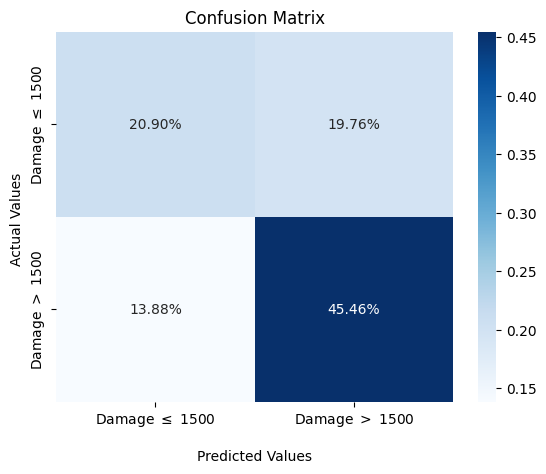

In [ ]:
# plot confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Damage $\leq$ 1500','Damage $>$ 1500'])
ax.yaxis.set_ticklabels(['Damage $\leq$ 1500','Damage $>$ 1500'])
plt.savefig("cf.png")
# Display the visualization of the Confusion Matrix
plt.show()

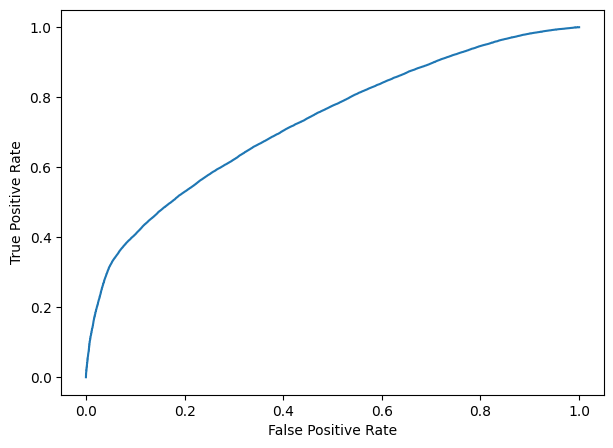

In [ ]:
#define metrics
y_pred_proba = eclf3.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("roc_curve.jpg")

# PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
categor_var = X.select_dtypes(include = "object").columns.to_list()
numeric_var = X.select_dtypes(include = ["float", "int"]).columns.to_list()
scaler = StandardScaler()
scaler.fit(X[numeric_var])
X[numeric_var] = scaler.fit_transform(X[numeric_var])

In [ ]:
# X_cont = X[numeric_var]
# print(X_cont.shape)
pca = PCA(n_components=X.shape[1])
X_pca = pca.fit_transform(X)
print(pca.explained_variance_ratio_.cumsum())

[0.12408318 0.19853695 0.25845494 0.31454755 0.36912078 0.42248187
 0.47556324 0.52783348 0.57792013 0.62754985 0.67139912 0.70538103
 0.73489093 0.75649931 0.77702574 0.79388706 0.81017906 0.8256353
 0.83877704 0.85093719 0.86125431 0.87095817 0.87968744 0.88766548
 0.89527314 0.90126027 0.9067297  0.91142459 0.916006   0.92049205
 0.92448225 0.92832657 0.93215488 0.93560093 0.9384425  0.94116765
 0.94360497 0.94600688 0.94833168 0.95043055 0.95250568 0.95453483
 0.95640767 0.95826661 0.96004635 0.96181621 0.96352524 0.96521809
 0.96678647 0.96833757 0.9698658  0.97128418 0.97262122 0.97394238
 0.97498424 0.97598794 0.97695563 0.97789998 0.97879488 0.97965313
 0.98050306 0.98128903 0.98205616 0.98281759 0.98356553 0.98419957
 0.98479765 0.98535822 0.985906   0.98642799 0.98692906 0.98741926
 0.98788719 0.98834307 0.98878371 0.98921596 0.98963298 0.99003169
 0.99042735 0.99081077 0.99117874 0.99154514 0.99189322 0.99218959
 0.99247276 0.99274505 0.99301353 0.99327093 0.99352398 0.99375

Text(40, 0.8, '80% line')

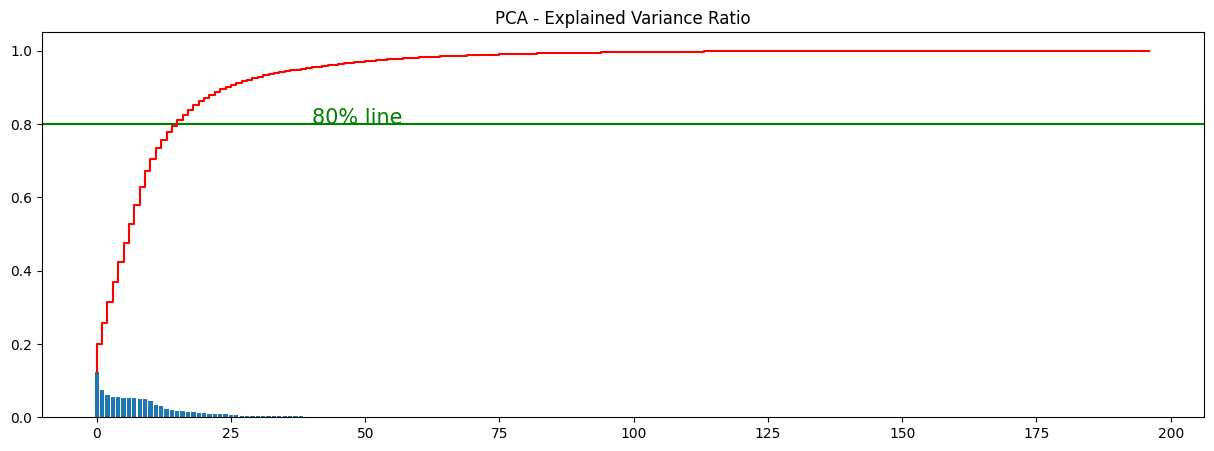

In [ ]:
# plot
feature_size = pca.n_components_
plt.figure(figsize=(15,5))
plt.title('PCA - Explained Variance Ratio')
plt.axhline(y=.80,color='green')
plt.bar(range(feature_size), pca.explained_variance_ratio_)
plt.step(range(feature_size), np.cumsum(pca.explained_variance_ratio_), color = 'red')
plt.text(40, 0.8, '80% line', color = 'green', fontsize = 15)

# EDA & Plots

In [ ]:
geometry = [Point(xy) for xy in zip(df['LONGITUDE'], df['LATITUDE'])]
gdf = GeoDataFrame(df, geometry=geometry)

In [ ]:
#this is a simple map that goes with geopandas
chicago = gpd.read_file("./geo_export_50f26c29-1b7f-4cb1-b1dc-f37705e8907d.shp")

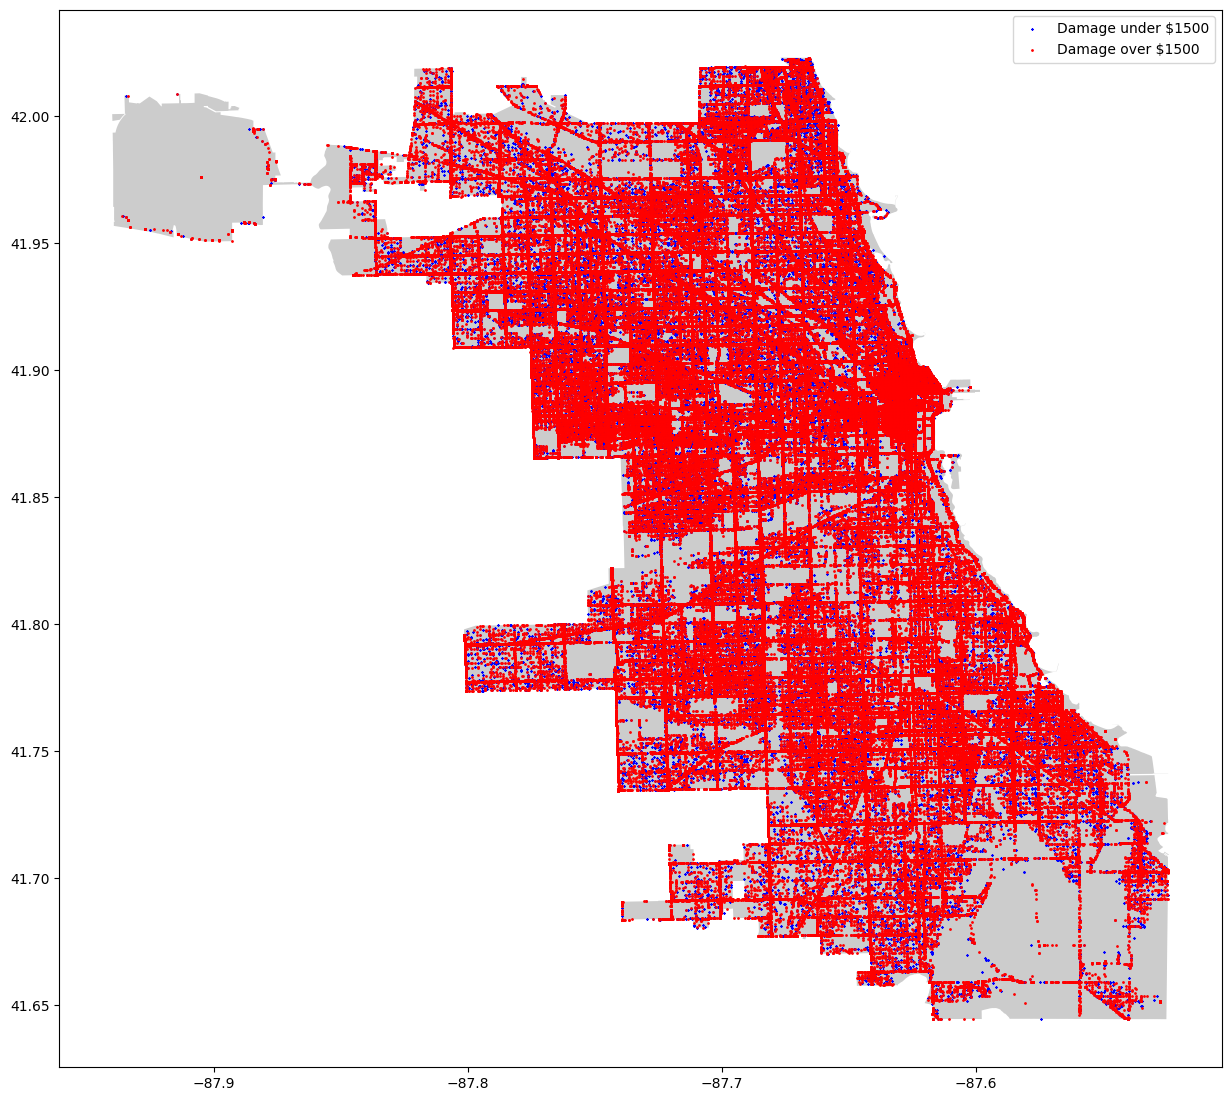

In [ ]:
fig, ax = plt.subplots(figsize=(15, 20))
chicago.plot(ax=ax, alpha=0.4, color='grey')
gdf[gdf['DAMAGE_OVER_1500'] == 0].plot(ax=ax, markersize=1, color='blue', marker='x', label='Damage under $1500')
gdf[gdf['DAMAGE_OVER_1500'] == 1].plot(ax=ax, markersize=1, color='red', marker='o', label='Damage over $1500')
plt.legend(prop={'size': 10})

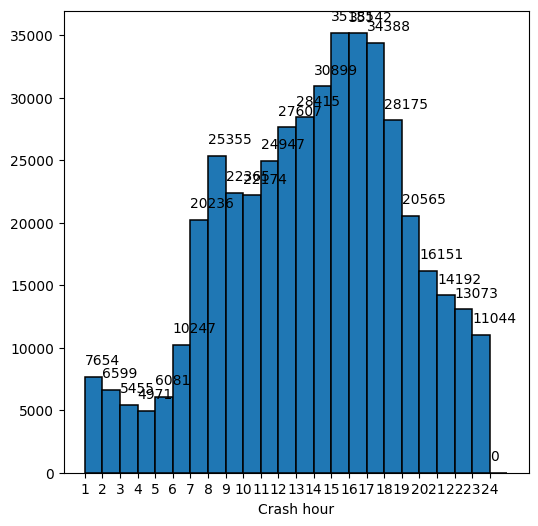

In [54]:
plt.figure(figsize=(6, 6))
counts, edges, _ = plt.hist(df['CRASH_HOUR'].astype('category'), bins=range(1, 26), edgecolor='black', linewidth=1.1, width=1)
plt.xlabel('Crash hour')
plt.xticks(range(1, 25))
for n, b in zip(counts, edges):
  plt.gca().text(b+0, n+1000, str(int(n)))  # +0.1 to center text

plt.show()

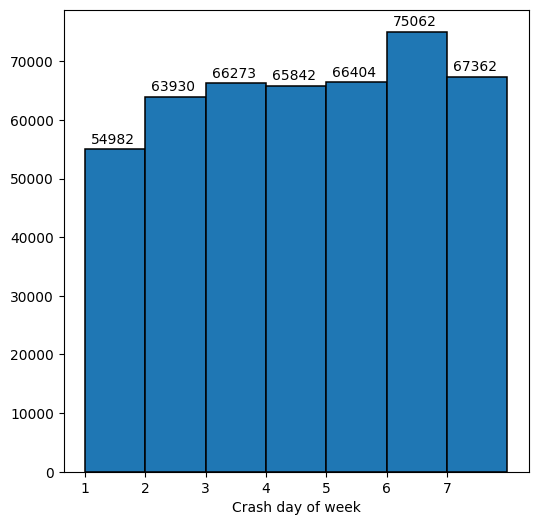

In [55]:
plt.figure(figsize=(6, 6))
counts, edges, _ = plt.hist(df['CRASH_DAY_OF_WEEK'].astype('category'), bins=range(1, 9), edgecolor='black', linewidth=1.1, width=1)
plt.xlabel('Crash day of week')
plt.xticks(range(1, 8))
for n, b in zip(counts, edges):
  plt.gca().text(b+0.1, n+1000, str(int(n)))  # +0.1 to center text

plt.show()

In [57]:
#variables with its data type and composition
h_col = df.columns[:7]
for i in h_col:
    print(i, ':')
    print('data type:', df[i].dtypes)
    print('Counter:', len(Counter(df[i])))
    print("============================")

POSTED_SPEED_LIMIT :
data type: int64
Counter: 41
TRAFFIC_CONTROL_DEVICE :
data type: object
Counter: 18
DEVICE_CONDITION :
data type: object
Counter: 7
WEATHER_CONDITION :
data type: object
Counter: 11
LIGHTING_CONDITION :
data type: object
Counter: 5
FIRST_CRASH_TYPE :
data type: object
Counter: 18
TRAFFICWAY_TYPE :
data type: object
Counter: 19


In [58]:
n = list()
for i in df.columns:
    n.append(i.lower())
n[21:]

['injuries_incapacitating',
 'injuries_non_incapacitating',
 'injuries_reported_not_evident',
 'injuries_no_indication',
 'crash_hour',
 'crash_day_of_week',
 'crash_month',
 'latitude',
 'longitude',
 'damage_over_1500']

#### POSTED_SPEED_LIMIT

In [59]:
#composition
Counter(df['POSTED_SPEED_LIMIT'])

Counter({30: 340019,
         15: 16130,
         20: 17455,
         35: 31583,
         10: 9497,
         45: 2875,
         25: 28310,
         40: 4585,
         0: 5453,
         5: 3086,
         50: 98,
         55: 351,
         29: 2,
         62: 1,
         39: 51,
         34: 12,
         1: 16,
         3: 120,
         24: 18,
         6: 5,
         14: 3,
         9: 83,
         22: 2,
         11: 7,
         60: 22,
         32: 12,
         12: 2,
         23: 1,
         33: 6,
         7: 2,
         26: 2,
         99: 10,
         2: 17,
         65: 8,
         70: 2,
         63: 1,
         38: 1,
         36: 1,
         4: 2,
         18: 2,
         31: 2})

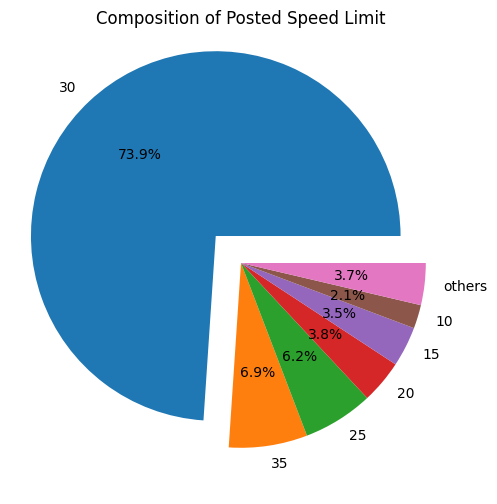

In [60]:
#pie chart
top_6 = Counter(df['POSTED_SPEED_LIMIT']).most_common(6)
other = len(df)
count, speed = list(), list()
for i in range(len(top_6)):
    other -= top_6[i][1]
    count.append(top_6[i][1])
    speed.append(top_6[i][0])
count.append(other)
speed.append('others')

myexplode = [0.2]+ [0]*6

plt.figure(figsize=(6,6))
plt.pie(count, labels = speed, explode = myexplode, autopct='%1.1f%%', textprops={'fontsize': 10})
plt.title('Composition of Posted Speed Limit')
plt.savefig('posted_speed_limit', dpi=300, bbox_inches='tight')

We can see that there are approximately 74% of posted speed limit is 30.

#### TRAFFIC_CONTROL_DEVICE

In [61]:
#composition
Counter(df['TRAFFIC_CONTROL_DEVICE'])

Counter({'NO CONTROLS': 272028,
         'TRAFFIC SIGNAL': 133563,
         'OTHER': 2586,
         'STOP SIGN/FLASHER': 47796,
         'OTHER WARNING SIGN': 437,
         'FLASHING CONTROL SIGNAL': 131,
         'RAILROAD CROSSING GATE': 307,
         'DELINEATORS': 142,
         'OTHER RAILROAD CROSSING': 112,
         'OTHER REG. SIGN': 535,
         'SCHOOL ZONE': 158,
         'YIELD': 622,
         'NO PASSING': 21,
         'PEDESTRIAN CROSSING SIGN': 243,
         'LANE USE MARKING': 961,
         'RR CROSSING SIGN': 35,
         'POLICE/FLAGMAN': 167,
         'BICYCLE CROSSING SIGN': 11})

Text(0.5, 1.0, 'Composition of Traffic Control Device')

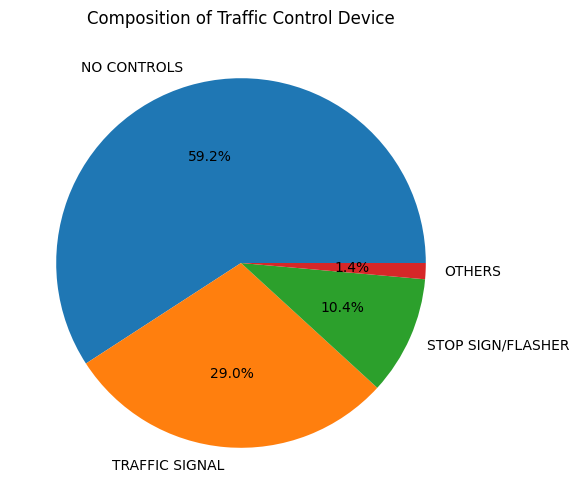

In [62]:
#pie chart
top_3 = Counter(df['TRAFFIC_CONTROL_DEVICE']).most_common(3)
other = len(df)
count, control_device = list(), list()
for i in range(len(top_3)):
    other -= top_3[i][1]
    count.append(top_3[i][1])
    control_device.append(top_3[i][0])
count.append(other)
control_device.append('OTHERS')
plt.figure(figsize=(6,6))
plt.pie(count, labels = control_device, autopct='%1.1f%%', textprops={'fontsize': 10})
plt.title('Composition of Traffic Control Device')
#plt.savefig('traffic_control_device', dpi=300, bbox_inches='tight')

#### DEVICE_CONDITION

In [63]:
#composition
Counter(df['DEVICE_CONDITION'])

Counter({'NO CONTROLS': 278097,
         'FUNCTIONING PROPERLY': 173993,
         'OTHER': 3370,
         'NOT FUNCTIONING': 1606,
         'FUNCTIONING IMPROPERLY': 2516,
         'WORN REFLECTIVE MATERIAL': 214,
         'MISSING': 59})

Text(0.5, 1.0, 'Composition of Device Condition')

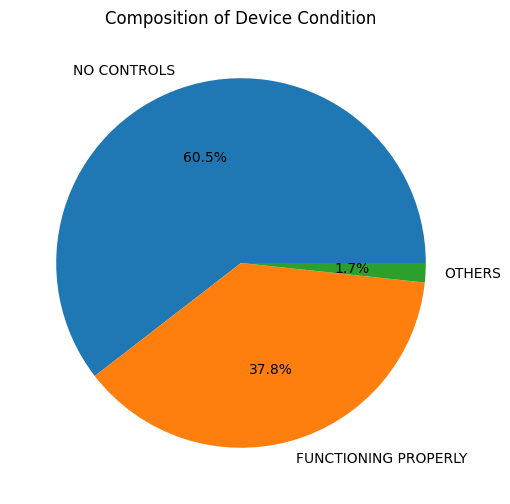

In [64]:
#pie chart
top_2 = Counter(df['DEVICE_CONDITION']).most_common(2)
other = len(df)
count, control_device = list(), list()
for i in range(len(top_2)):
    other -= top_2[i][1]
    count.append(top_2[i][1])
    control_device.append(top_2[i][0])
count.append(other)
control_device.append('OTHERS')
plt.figure(figsize=(6,6))
plt.pie(count, labels = control_device, autopct='%1.1f%%', textprops={'fontsize': 10})
plt.title('Composition of Device Condition')
#plt.savefig('device_condition', dpi=300, bbox_inches='tight')

#### WEATHER_CONDITION

In [65]:
#composition
Counter(df['WEATHER_CONDITION'])

Counter({'CLEAR': 385082,
         'RAIN': 40132,
         'OTHER': 1233,
         'CLOUDY/OVERCAST': 13737,
         'SNOW': 17390,
         'SLEET/HAIL': 631,
         'BLOWING SNOW': 184,
         'FREEZING RAIN/DRIZZLE': 673,
         'SEVERE CROSS WIND GATE': 85,
         'FOG/SMOKE/HAZE': 707,
         'BLOWING SAND, SOIL, DIRT': 1})

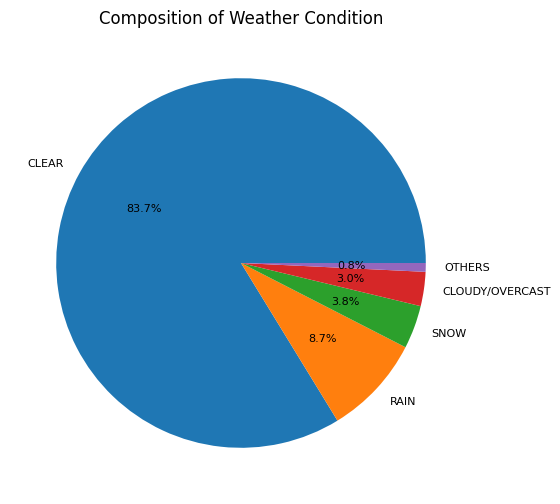

In [66]:
#pie chart
top_4 = Counter(df['WEATHER_CONDITION']).most_common(4)
other = len(df)
count, control_device = list(), list()
for i in range(len(top_4)):
    other -= top_4[i][1]
    count.append(top_4[i][1])
    control_device.append(top_4[i][0])
count.append(other)
control_device.append('OTHERS')
plt.figure(figsize=(6,6))
plt.pie(count, labels = control_device, autopct='%1.1f%%', textprops={'fontsize': 8})
plt.title('Composition of Weather Condition')
plt.savefig('weather_condition', dpi=300, bbox_inches='tight')

We can see that there are approximately 83.7% of weather condition is 'clear'.

#### LIGHTING_CONDITION

In [67]:
#composition
Counter(df['LIGHTING_CONDITION'])

Counter({'DARKNESS, LIGHTED ROAD': 103188,
         'DAYLIGHT': 313806,
         'DAWN': 8032,
         'DARKNESS': 20998,
         'DUSK': 13831})

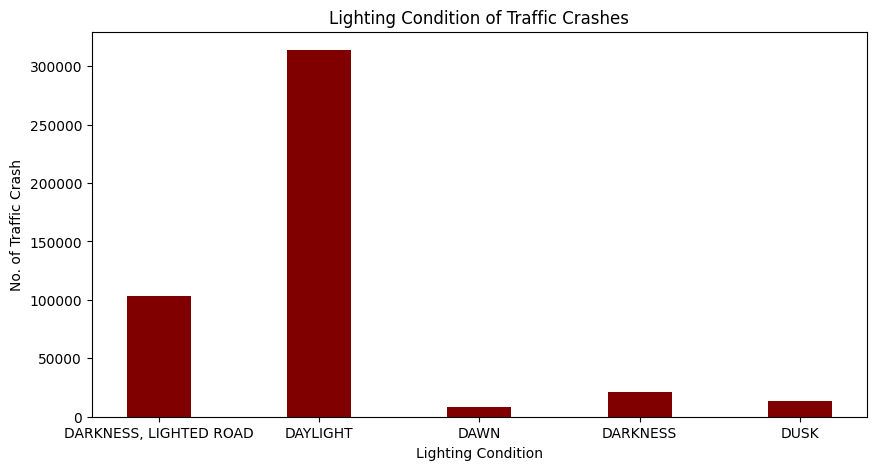

In [73]:
#barplot of LIGHTING_CONDITION
lighting = list(Counter(df['LIGHTING_CONDITION']).keys())
count = list(Counter(df['LIGHTING_CONDITION']).values())

plt.figure(figsize=(10, 5))
plt.bar(lighting, count, color ='maroon',
        width = 0.4)
plt.xlabel("Lighting Condition")
plt.ylabel("No. of Traffic Crash")
plt.title("Lighting Condition of Traffic Crashes")
plt.show()

<Axes: title={'center': 'Stacked Bar Graph of Lighting Condition and Damage'}, xlabel='lighting condition'>

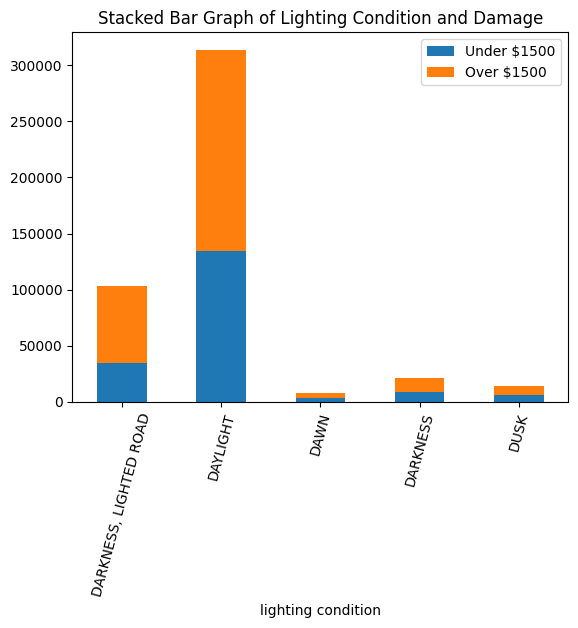

In [74]:
#stacked barplot of LIGHTING_CONDITION
lighting = list(Counter(df['LIGHTING_CONDITION']).keys())
data = list()
for i in lighting:
    n_over_1500 = len(df.loc[(df['LIGHTING_CONDITION']==i) & (df['DAMAGE_OVER_1500']==1)])
    n_under_1500 = len(df.loc[(df['LIGHTING_CONDITION']==i) & (df['DAMAGE_OVER_1500']==0)])
    data.append([i, n_under_1500, n_over_1500])
df_lighting = pd.DataFrame(data, columns = ['lighting condition', 'Under $1500', 'Over $1500'])
df_lighting.plot(x='lighting condition', kind='bar', stacked=True,
        title='Stacked Bar Graph of Lighting Condition and Damage', rot = 75)
#plt.savefig('lighting_condition', dpi=300, bbox_inches='tight')

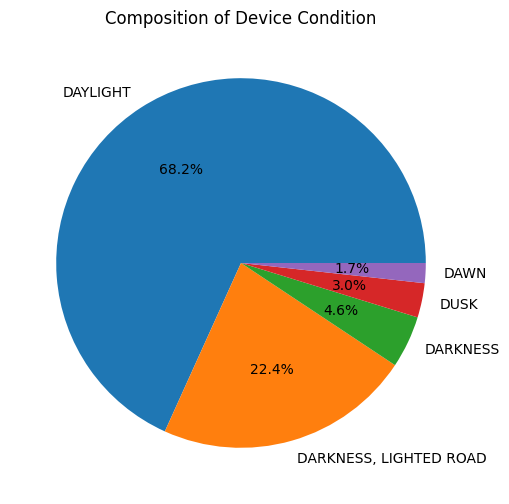

In [75]:
#pie chart
top_5 = Counter(df['LIGHTING_CONDITION']).most_common(5)
count, control_device = list(), list()
for i in range(len(top_5)):
    other -= top_5[i][1]
    count.append(top_5[i][1])
    control_device.append(top_5[i][0])
plt.figure(figsize=(6,6))
plt.pie(count, labels = control_device, autopct='%1.1f%%', textprops={'fontsize': 10})
plt.title('Composition of Device Condition')
#plt.savefig('device_condition', dpi=300, bbox_inches='tight')
plt.savefig('lighting_condition_pie', dpi=300, bbox_inches='tight')

#### FIRST_CRASH_TYPE

In [76]:
#composition
Counter(df['FIRST_CRASH_TYPE'])

Counter({'PARKED MOTOR VEHICLE': 98968,
         'REAR TO REAR': 722,
         'SIDESWIPE SAME DIRECTION': 71337,
         'REAR END': 108680,
         'TURNING': 67251,
         'PEDESTRIAN': 10474,
         'ANGLE': 51065,
         'SIDESWIPE OPPOSITE DIRECTION': 6841,
         'OTHER OBJECT': 4362,
         'OTHER NONCOLLISION': 1451,
         'FIXED OBJECT': 22017,
         'REAR TO FRONT': 3249,
         'REAR TO SIDE': 1932,
         'ANIMAL': 319,
         'HEAD ON': 4009,
         'PEDALCYCLIST': 6871,
         'OVERTURNED': 282,
         'TRAIN': 25})

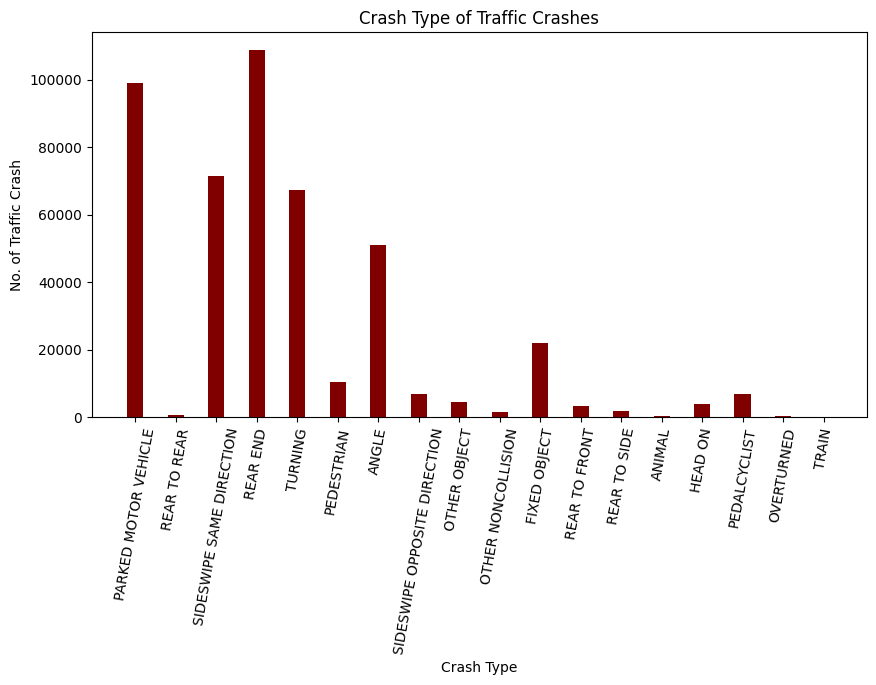

In [77]:
#barplot of FIRST_CRASH_TYPE
crash_type = list(Counter(df['FIRST_CRASH_TYPE']).keys())
count = list(Counter(df['FIRST_CRASH_TYPE']).values())

fig = plt.figure(figsize = (10, 5))

plt.bar(crash_type, count, color ='maroon',
        width = 0.4)

plt.xlabel("Crash Type")
plt.ylabel("No. of Traffic Crash")
plt.title("Crash Type of Traffic Crashes")
plt.xticks(fontsize = 10, rotation = 80)
plt.show()

<Axes: title={'center': 'Stacked Bar Graph of Crash Type and Damage'}, xlabel='crash type'>

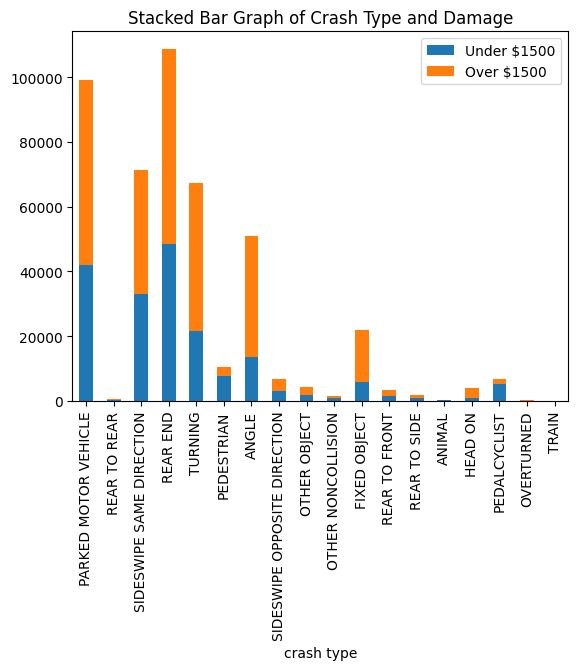

In [78]:
#stacked barplot of FIRST_CRASH_TYPE
crash_type = list(Counter(df['FIRST_CRASH_TYPE']).keys())
data = list()
for i in crash_type:
    n_over_1500 = len(df.loc[(df['FIRST_CRASH_TYPE']==i) & (df['DAMAGE_OVER_1500']==1)])
    n_under_1500 = len(df.loc[(df['FIRST_CRASH_TYPE']==i) & (df['DAMAGE_OVER_1500']==0)])
    data.append([i, n_under_1500, n_over_1500])
df_lighting = pd.DataFrame(data, columns = ['crash type', 'Under $1500', 'Over $1500'])
df_lighting.plot(x='crash type', kind='bar', stacked=True,
        title='Stacked Bar Graph of Crash Type and Damage')
#plt.savefig('crash_type', dpi=300, bbox_inches='tight')

#### TRAFFICWAY_TYPE

In [79]:
#composition
Counter(df['TRAFFICWAY_TYPE'])

Counter({'ONE-WAY': 57897,
         'PARKING LOT': 31160,
         'FOUR WAY': 20031,
         'NOT DIVIDED': 207074,
         'DIVIDED - W/MEDIAN (NOT RAISED)': 82029,
         'T-INTERSECTION': 4096,
         'OTHER': 12428,
         'DIVIDED - W/MEDIAN BARRIER': 28559,
         'ALLEY': 7351,
         'RAMP': 1407,
         'UNKNOWN INTERSECTION TYPE': 845,
         'DRIVEWAY': 1577,
         'TRAFFIC ROUTE': 383,
         'CENTER TURN LANE': 3731,
         'FIVE POINT, OR MORE': 468,
         'Y-INTERSECTION': 469,
         'NOT REPORTED': 181,
         'L-INTERSECTION': 64,
         'ROUNDABOUT': 105})

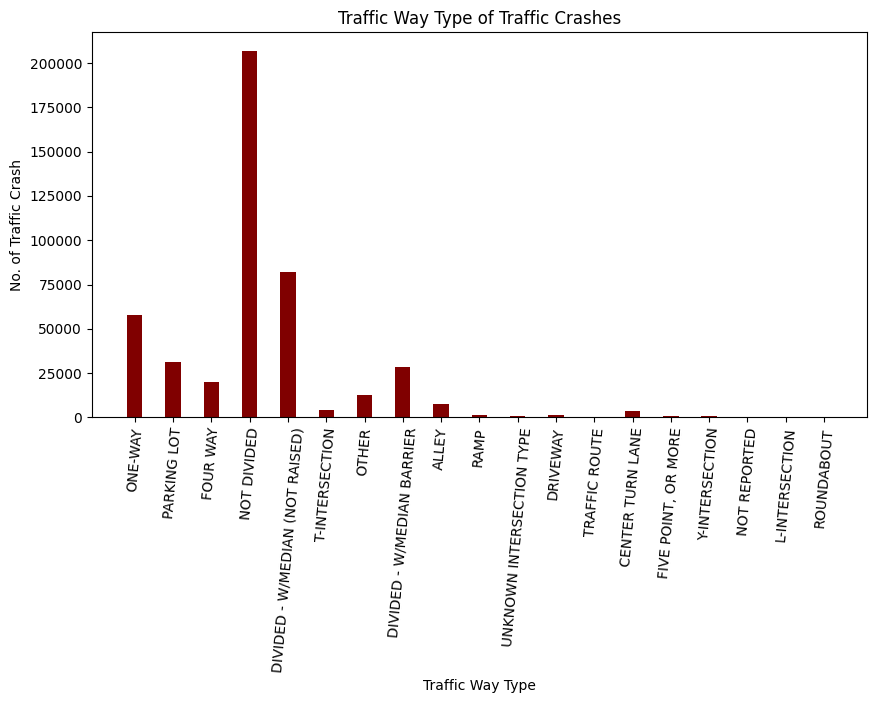

In [80]:
#barplot of TRAFFICWAY_TYPE
traffic_way_type = list(Counter(df['TRAFFICWAY_TYPE']).keys())
count = list(Counter(df['TRAFFICWAY_TYPE']).values())

fig = plt.figure(figsize = (10, 5))

plt.bar(traffic_way_type, count, color ='maroon',
        width = 0.4)

plt.xlabel("Traffic Way Type")
plt.ylabel("No. of Traffic Crash")
plt.title("Traffic Way Type of Traffic Crashes")
plt.xticks(fontsize = 10, rotation = 85)
plt.show()

<Axes: title={'center': 'Stacked Bar Graph of Traffic Way Type and Damage'}, xlabel='traffic way type'>

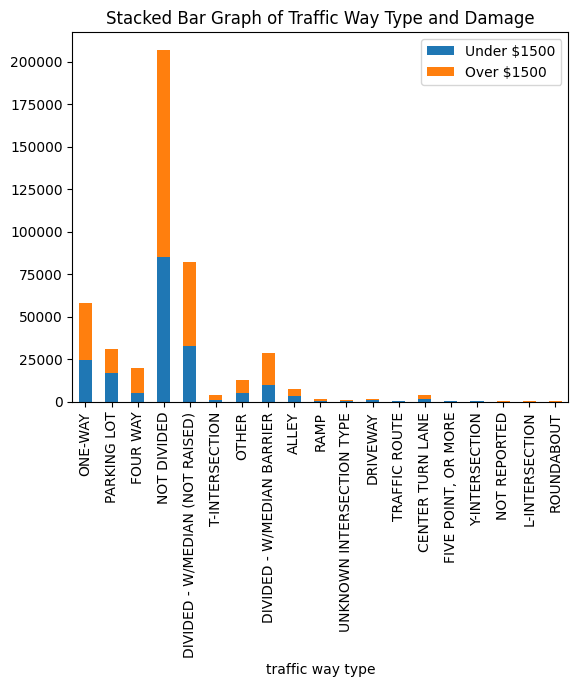

In [81]:
#stacked barplot of TRAFFICWAY_TYPE
traffic_way_type = list(Counter(df['TRAFFICWAY_TYPE']).keys())
data = list()
for i in traffic_way_type:
    n_over_1500 = len(df.loc[(df['TRAFFICWAY_TYPE']==i) & (df['DAMAGE_OVER_1500']==1)])
    n_under_1500 = len(df.loc[(df['TRAFFICWAY_TYPE']==i) & (df['DAMAGE_OVER_1500']==0)])
    data.append([i, n_under_1500, n_over_1500])
df_lighting = pd.DataFrame(data, columns = ['traffic way type', 'Under $1500', 'Over $1500'])
df_lighting.plot(x='traffic way type', kind='bar', stacked=True,
        title='Stacked Bar Graph of Traffic Way Type and Damage')
#plt.savefig('traffic_way_type', dpi=300, bbox_inches='tight')